In [0]:
import tensorflow as tf
print(tf.__version__)
import math

2.2.0-rc4


In [0]:
from keras import backend

Using TensorFlow backend.


In [0]:
from google.colab import files
import io
import pandas as pd
import numpy as np


In [0]:
uploaded = files.upload()

Saving AAPL_data.csv to AAPL_data.csv


In [0]:
  aapl = pd.read_csv(io.BytesIO(uploaded['AAPL_data.csv']))

In [0]:
aapl.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [0]:
aapl['close'].isnull().sum()

0

In [0]:
aapl.shape

(1259, 7)

In [0]:
series = aapl['close']
print(series)
type(series)
time = np.arange(0,1259,1)
print(time)

0        67.8542
1        68.5614
2        66.8428
3        66.7156
4        66.6556
          ...   
1254    167.7800
1255    160.5000
1256    156.4900
1257    163.0300
1258    159.5400
Name: close, Length: 1259, dtype: float64
[   0    1    2 ... 1256 1257 1258]


In [0]:
print(series.shape,time.shape)

(1259,) (1259,)


In [0]:
series = pd.Series.to_numpy(series)

In [0]:
series.shape

In [0]:
series

array([ 67.8542,  68.5614,  66.8428, ..., 156.49  , 163.03  , 159.54  ])

In [0]:
time.shape

(1259,)

In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 20
batch_size = 33
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(24, return_sequences=True),
  tf.keras.layers.LSTM(24, return_sequences=True),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1200,)
Epoch 1/200
36/36 [==============================] - 0s 7ms/step - loss: 118.8648 - mse: 15192.5645 - lr: 1.0000e-08
Epoch 2/200
36/36 [==============================] - 0s 6ms/step - loss: 108.1827 - mse: 12894.7051 - lr: 1.1220e-08
Epoch 3/200
36/36 [==============================] - 0s 6ms/step - loss: 97.1527 - mse: 10786.1631 - lr: 1.2589e-08
Epoch 4/200
36/36 [==============================] - 0s 7ms/step - loss: 88.3786 - mse: 9160.2402 - lr: 1.4125e-08
Epoch 5/200
36/36 [==============================] - 0s 7ms/step - loss: 83.3551 - mse: 8272.4844 - lr: 1.5849e-08
Epoch 6/200
36/36 [==============================] - 0s 6ms/step - loss: 80.3538 - mse: 7770.5200 - lr: 1.7783e-08
Epoch 7/200
36/36 [==============================] - 0s 6ms/step - loss: 77.0681 - mse: 7243.1777 - lr: 1.9953e-08
Epoch 8/200
36/36 [==============================] - 0s 7ms/step - loss: 73.4928 - mse: 

(1e-08, 0.0001, 0.0, 60.0)

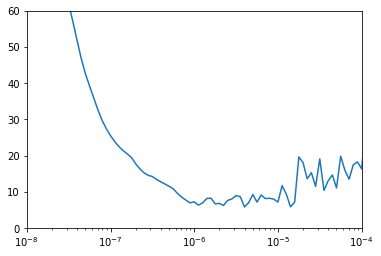

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=20, batch_size=33, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
33/33 [==============================] - 0s 8ms/step - loss: 43.7136 - mse: 4089.4241
Epoch 2/200
33/33 [==============================] - 0s 6ms/step - loss: 12.6369 - mse: 273.4251
Epoch 3/200
33/33 [==============================] - 0s 7ms/step - loss: 7.1388 - mse: 99.9794
Epoch 4/200
33/33 [==============================] - 0s 7ms/step - loss: 6.0231 - mse: 78.6659
Epoch 5/200
33/33 [==============================] - 0s 7ms/step - loss: 8.4215 - mse: 118.7970
Epoch 6/200
33/33 [==============================] - 0s 7ms/step - loss: 4.8985 - mse: 53.3905
Epoch 7/200
33/33 [==============================] - 0s 7ms/step - loss: 4.1504 - mse: 39.1714
Epoch 8/200
33/33 [==============================] - 0s 7ms/step - loss: 5.4742 - mse: 56.7618
Epoch 9/200
33/33 [==============================] - 0s 6ms/step - loss: 4.0753 - mse: 37.6858
Epoch 10/200
33/33 [==============================] - 0s 6ms/step - loss: 3.7890 - mse: 32.7637
Epoch 11/200
33/33 [=======================

##Saving the model

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()

96.88349

In [0]:
RMSE = math.sqrt(tf.keras.metrics.mse(x_valid, rnn_forecast).numpy())
print('RMSE is equal to %.5f' %RMSE)

RMSE is equal to 9.84294


In [0]:
print(model)

In [0]:
model.save("APPLE_model_deployed.h5")

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          330       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:

time_valid.shape

(59,)

Text(0.5, 1.0, 'APPLE stock Predicton vs Actual')

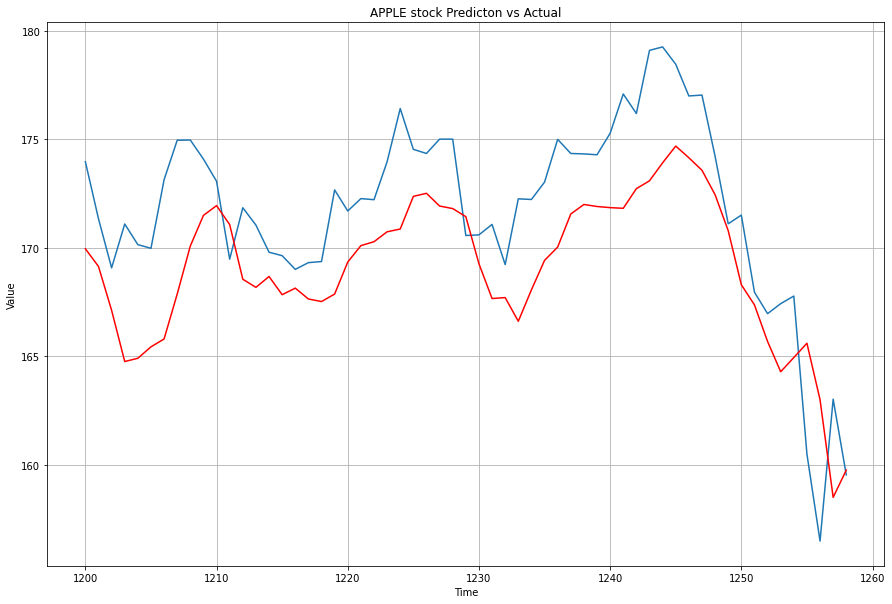

In [0]:
plt.figure(figsize=(15,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,'#ff0000')
plt.title("APPLE stock Predicton vs Actual")

In [0]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


<Figure size 864x648 with 0 Axes>

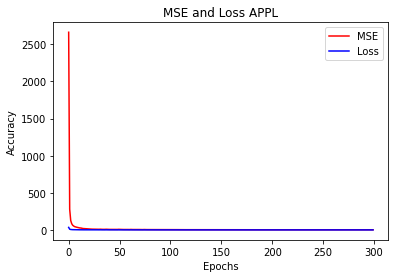

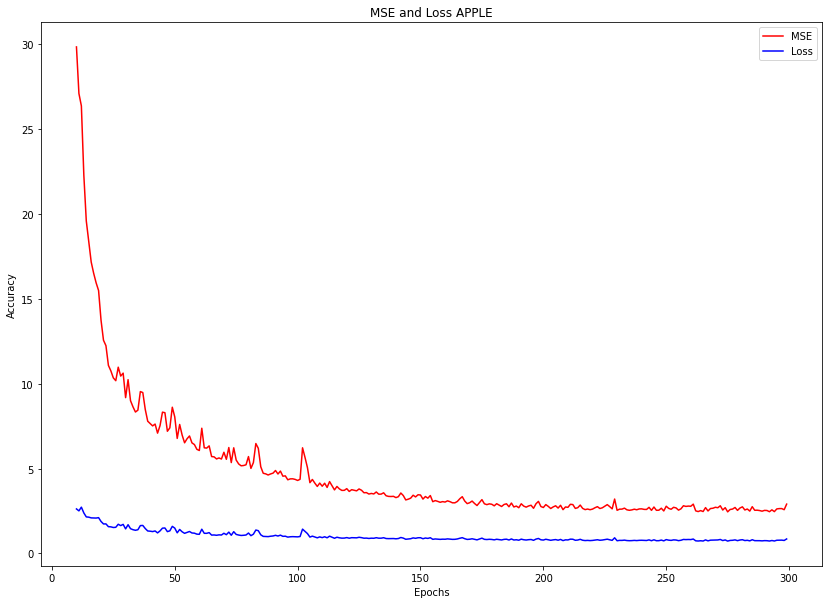

<Figure size 864x648 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss APPL')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

epochs_zoom = epochs[10:]
mse_zoom = mse[10:]
loss_zoom = loss[10:]
plt.figure(figsize=(14,10))

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss APPLE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])
plt.figure(figsize=(12,9))


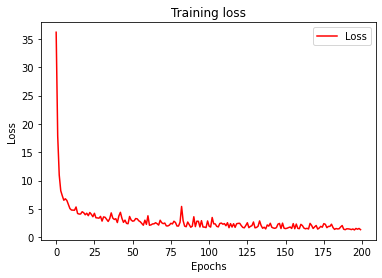

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()
zoomed_loss = loss[100:]
zoomed_epochs = range(100,200)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

9.552001

<Figure size 432x288 with 0 Axes>

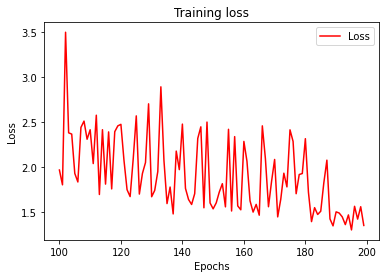

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()


In [0]:
print(rnn_forecast)

[109.76545  110.33736  110.77261  110.317924 108.75132  107.444145
 107.93955  110.016045 112.37967  114.32917  115.30032  115.08675
 114.494095 114.6909   114.97684  115.01107  114.94706  115.303505
 115.313194 115.15333  114.81378  114.940735 115.080475 115.28988
 115.6282   116.320465 116.99939  117.67976  118.08169  118.30907
 118.434105 118.53101  118.456566 118.331406 118.18466  118.266205
 118.60475  118.50914  117.65972  116.24839  115.48894  114.86406
 114.220024 113.273384 112.53488  112.23141  112.56516  113.21691
 112.83957  111.78993  110.15544  109.640335 110.09267  111.26559
 112.356674 112.98616  113.43131  113.76739  113.78396  113.53838
 113.73224  113.62546  112.9629   112.45429  112.15732  112.21223
 112.577126 113.35293  114.37234  115.11476  115.71558  116.14945
 116.66702  116.95957  117.29948  117.668106 118.0403   118.05596
 117.88945  117.95554  118.10691  118.1968   117.89915  117.648544
 117.5229   117.653564 118.05969  118.78475  119.458595 120.19505
 120.4

In [0]:
pl